In [1]:
### >> EXPLORATORY DATA ANALYSIS OF STACK OVERFLOW DATA << ###

In [2]:
# Importing Modules
import pymongo
import wordcloud
import numpy as np
import pandas as pd
import seaborn as sb
import collections as C
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Connecting to Local MongoDB Client
client = pymongo.MongoClient('localhost', 27017)
db = client['StackOverflow']

In [4]:
### EDA on Tags Collection ###

In [5]:
# Loading the Tags Collection as Pandas Dataframe
cursor = db['Tags'].find({})[1:]
df = pd.DataFrame(list(cursor))
del df['_id']

# Selecting relevant columns
df = df[["TagName","Count"]]
df["Count"]=df["Count"].astype(int)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

df.sort_values(inplace=True,axis=0,by=["Count"],ascending=False)
df.head()

,TagName,Count
2,javascript,1955557
11,java,1641102
6,c#,1385220
10,python,1359126
4,php,1335050


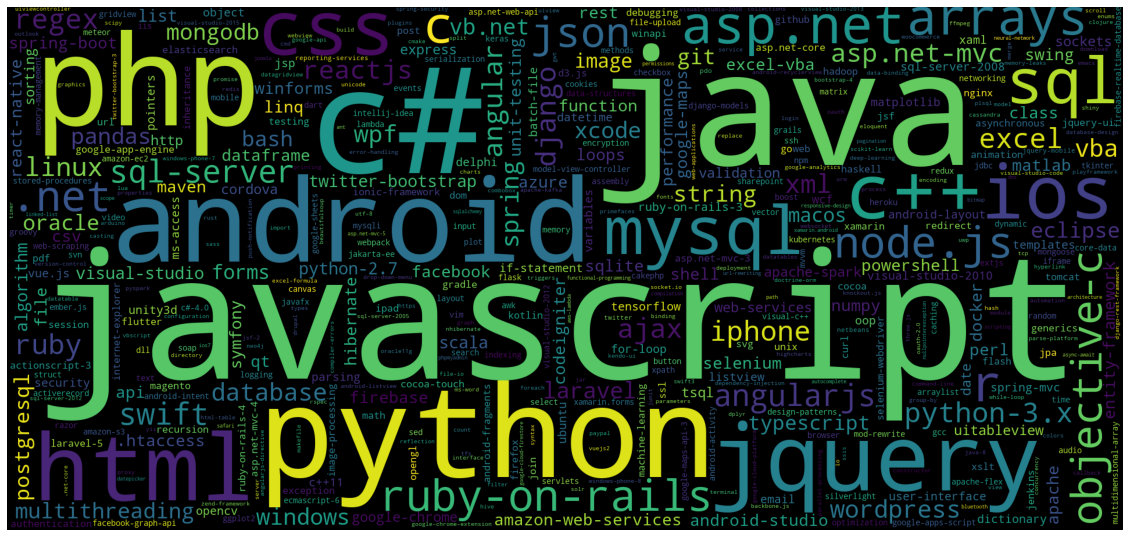

In [6]:
# Creating Word Cloud for Tags based on their frequency

cloud = wordcloud.WordCloud(max_font_size=300,width=1920,height=900,max_words=500,relative_scaling=0.5)
Data = { tag : count for tag,count in df.values}
cloud.generate_from_frequencies(Data)
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(cloud)
plt.savefig('WordCloud_StackOverflow.png')

In [7]:
### EDA on Posts Collection ###

In [8]:
# Traversing the Posts Collection and analysing the distribution of Tags

cursor = db['Posts'].find({})[1:]
Post_Tags = {}
Total_Posts = 0
Tagged_Posts = 0

for x in cursor:
    if 'Tags' in x:
        Tag_List = list(x['Tags'][1:-1].split("><"))
        for t in Tag_List:
            if t in Post_Tags: 
                Post_Tags[t] += 1
            else: 
                Post_Tags[t] = 1
        Tagged_Posts += 1
    Total_Posts += 1

print("Total Posts :",Total_Posts)
print("Tagged Posts :",Tagged_Posts)
print("Unique Tags :",len(Post_Tags))

Total Posts : 3380601
Tagged Posts : 1358860
Unique Tags : 22512


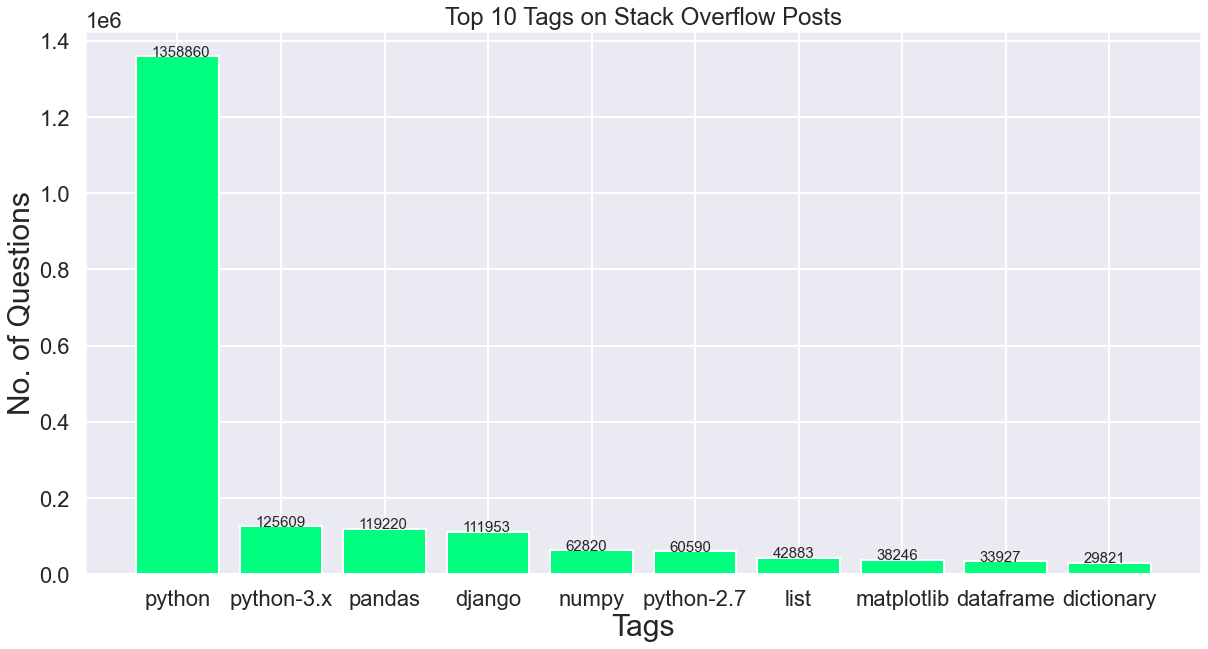

In [9]:
# Plotting Top 10 Tags

Tag_List = [(Post_Tags[i],i) for i in Post_Tags]
Tag_List.sort(reverse=True)
Top_Tags = Tag_List[:10]

sb.set_theme(context = "poster", style='darkgrid')
plt.figure(figsize=(20,10))
x = [i[1] for i in Top_Tags]
y = [i[0] for i in Top_Tags]
plt.bar(x,y,color='springgreen')
for i in range(len(y)):
    plt.text(i-0.25,y[i],str(y[i]),fontsize=15)
plt.xlabel("Tags",fontsize =30) 
plt.ylabel("No. of Questions",fontsize = 30) 
plt.title("Top 10 Tags on Stack Overflow Posts")
plt.savefig('Top_10_Tags.png')

In [10]:
# Counting unique instances of  attributes in Posts to identify subsampling critera

Attributes = set()

cursor = db['Posts'].find({})[1:]
for x in cursor:
    Attributes = Attributes.union(set(x.keys()))

Attribute_Sets = {i:set() for i in Attributes}

cursor = db['Posts'].find({})[1:]
for x in cursor:
    for i in Attributes:
        if i in x:
            Attribute_Sets[i].add(x[i])

X = []
for i in Attributes:
    X.append((len(Attribute_Sets[i]),i))
X.sort()

for i in X:
    print(i[1],i[0])

PostTypeId 2
AnswerCount 53
CommentCount 53
FavoriteCount 396
Score 1230
CommunityOwnedDate 5534
LastEditorDisplayName 5733
OwnerDisplayName 15482
ViewCount 40082
ClosedDate 84382
LastEditorUserId 262918
Tags 467829
OwnerUserId 670395
AcceptedAnswerId 730440
ParentId 1158038
Title 1358340
LastEditDate 1410408
LastActivityDate 2501726
CreationDate 3377143
Body 3380053
_id 3380601


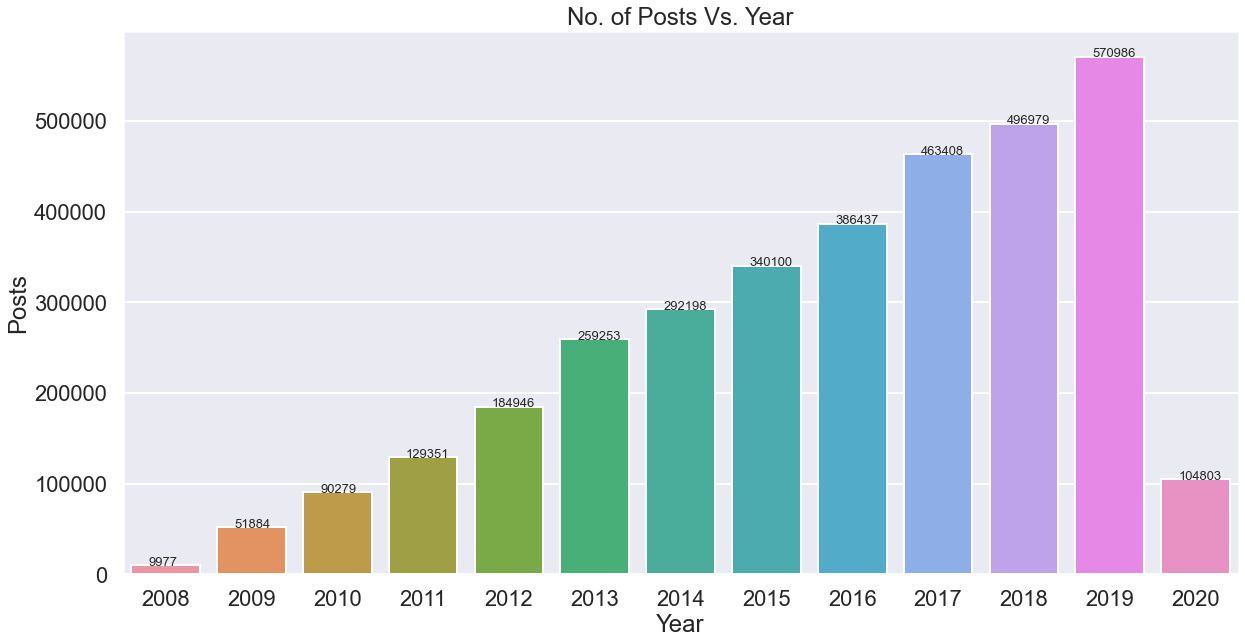

In [11]:
# Analysing Activity on Stack Overflow over the years

cursor = db['Posts'].find({})[1:]

Activity = {}

for x in cursor:
    Year = x['CreationDate'][:4]
    if Year in Activity:
        Activity[Year] += 1
    else:
        Activity[Year] = 1

df = pd.DataFrame()
df['Year'] = [i for i in Activity]
df['Posts'] = [Activity[i] for i in Activity]

sb.set_theme(context = "poster", style='darkgrid')
plt.figure(figsize=(20,10))
g = sb.barplot(data=df,x="Year",y="Posts")
Y = list(df['Posts'])
for i in range(len(Y)):
    g.text(i-0.2,Y[i],str(Y[i]),fontsize=13)
plt.title("No. of Posts Vs. Year")
plt.savefig('Year_Activity.png')

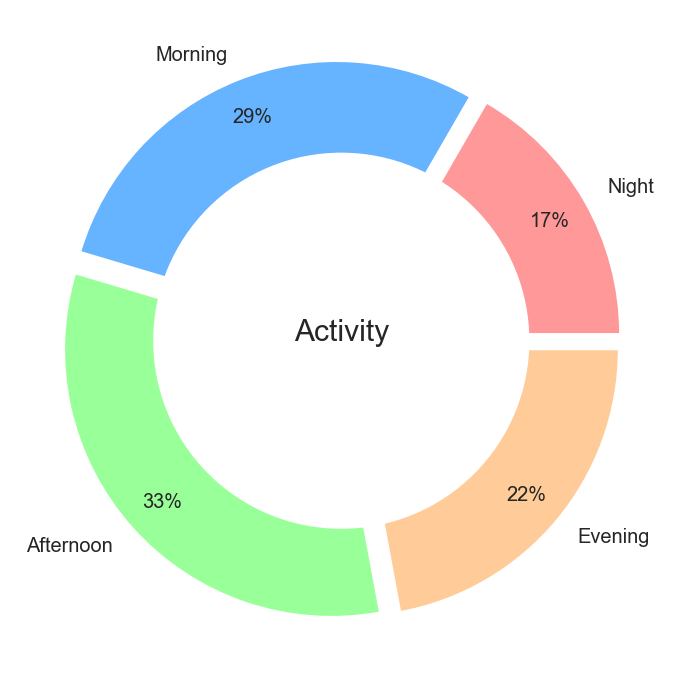

In [20]:
# Tracking Activity on StackOverflow through the day

cursor = db['Posts'].find({})[1:]

Periods = {"Night":0,"Morning":0,"Afternoon":0,"Evening":0}

for x in cursor:
    A = int(x['CreationDate'][11:13])
    if A>=0 and A<6: Periods["Night"]+=1
    elif A>=6 and A<=12: Periods["Morning"]+=1
    elif A>=12 and A<=18: Periods["Afternoon"]+=1
    elif A>=18 and A<=24: Periods["Evening"]+=1
 
df = pd.DataFrame()
df['Period'] = [i for i in Periods]
df['Posts'] = [Periods[i] for i in Periods]

sizes = list(Periods.values())
labels = list(Periods.keys())
explode = (0.05,0.05,0.05,0.05)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

sb.set_theme(context = "poster", style='darkgrid')
plt.figure(figsize=(10,10))
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.0f%%', pctdistance=0.85, explode = explode,textprops={'fontsize': 20})
fig = plt.gcf()
fig.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))
fig.gca().annotate("Activity", xy=(0, 0), fontsize=30,ha="center")
plt.tight_layout()
plt.savefig('Day_Activity.png')

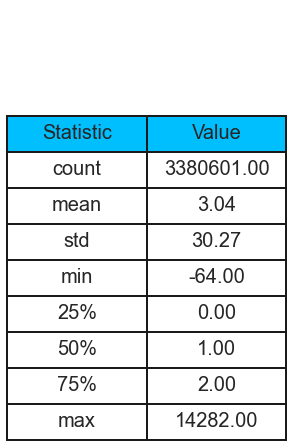

In [8]:
# Distribution of Scores

cursor = db['Posts'].find({})[1:]

Scores = []

for x in cursor:
    Scores.append(int(x['Score']))

df = pd.DataFrame()
df['Scores'] = Scores
Temp = df.describe().apply(lambda s: s.apply('{0:.2f}'.format))
X = [Temp.index,Temp["Scores"]]
X = list(map(list, zip(*X)))

plt.figure(figsize=(5,2))
plt.axis('off')
T = plt.table(X, cellLoc='center',colLabels=["Statistic","Value"],colColours=['deepskyblue','deepskyblue'])
T.set_fontsize(20)
T.scale(1, 3)
plt.savefig('Scores_Stats.png')

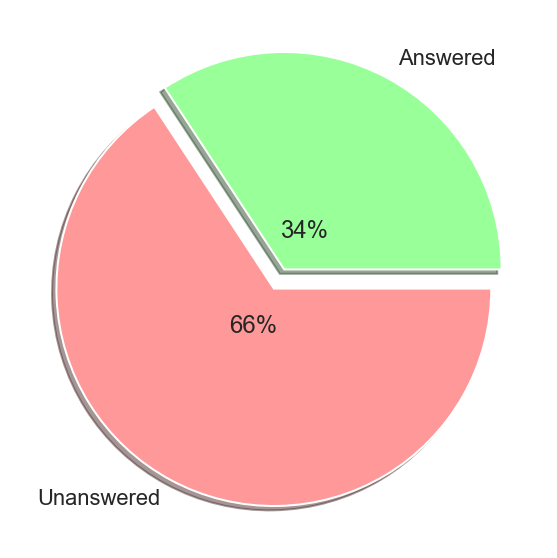

In [4]:
# Determining distribution of Answered and Unanswered posts

cursor = db['Posts'].find({})[1:]

Answered = 0
Unanswered = 0

for x in cursor:
    if 'AnswerCount' in x and int(x['AnswerCount'])>0:
        Answered+=1
    else:
        Unanswered+=1

sb.set_theme(context = "poster", style='darkgrid')
plt.figure(figsize=(20,10))
x = [Answered,Unanswered]
plt.pie(x,labels=["Answered","Unanswered"],explode=(0.05,0.05),colors=['#99ff99','#ff9999'], autopct='%1.0f%%', shadow=True, startangle=0,   pctdistance=0.2,labeldistance=1.1)
plt.savefig('Answers.png')


In [ ]:
### EDA on Users Collection ###

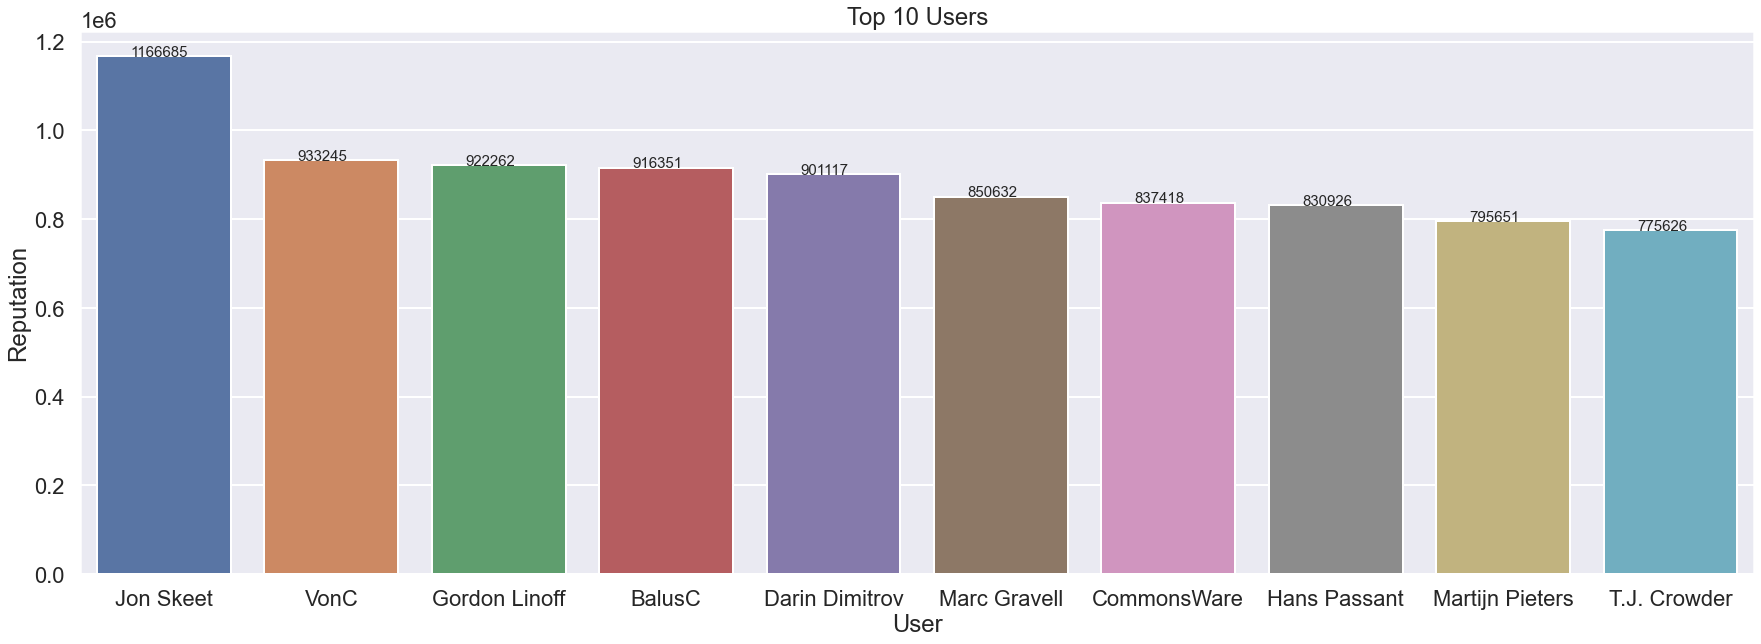

In [9]:
# Finding most reputed users of Stack Overflow

cursor = db['Users'].find({})[1:]

Pro = []
Rep = []

for x in cursor:
    if 'Reputation' in x and 'DisplayName' in x :
        R = int(x['Reputation'])
        N = x['DisplayName']
        Pro.append((R,N))
        Rep.append(R)
        
Pro.sort(reverse=True)
Pro = Pro[:10]

df = pd.DataFrame()
df["User"] = [ i[1] for i in Pro ]
df["Reputation"] = [ i[0] for i in Pro ]

sb.set_theme(context = "poster", style='darkgrid')
plt.figure(figsize=(30,10))
g = sb.barplot(data=df,x="User",y="Reputation")
Y = list(df["Reputation"])
for i in range(len(Y)):
    g.text(i-0.2,Y[i],str(Y[i]),fontsize=15)
plt.title("Top 10 Users")
plt.savefig('Top_Users.png')

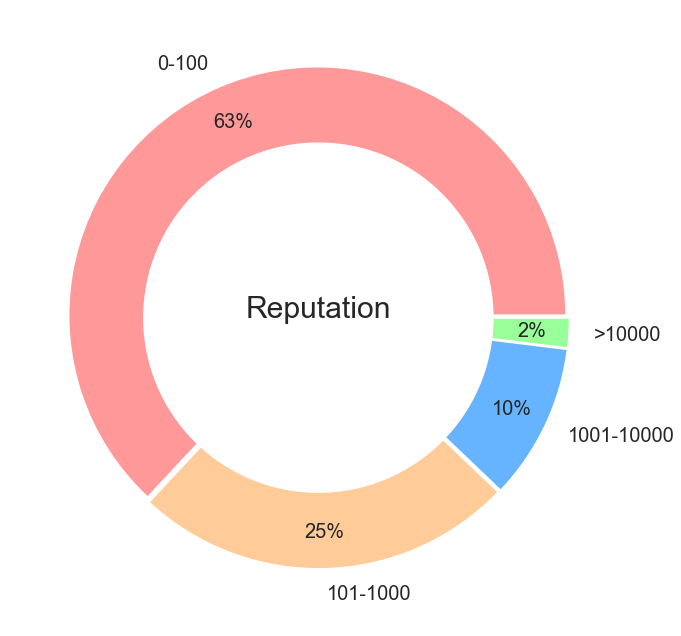

In [21]:
# Analysing Distribution of Reputation

X = [0 for i in range(4)]

for i in Rep:
    if i<=100: X[0]+=1
    elif i<=1000: X[1]+=1
    elif i<=10000: X[2]+=1
    else: X[3]+=1


sizes = X
labels = ['0-100','101-1000','1001-10000','>10000']
explode = (0.01,0.01,0.01,0.01)
colors = ['#ff9999','#ffcc99','#66b3ff','#99ff99']

sb.set_theme(context = "poster", style='darkgrid')
plt.figure(figsize=(10,10))
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.0f%%', pctdistance=0.85, explode = explode,textprops={'fontsize': 20})
fig = plt.gcf()
fig.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))
fig.gca().annotate("Reputation", xy=(0, 0), fontsize=30,ha="center")
plt.tight_layout()
plt.savefig('Reputation.png')

In [ ]:
### END OF NOTEBOOK ###